INTRODUCTION

The goal of this competition is to classify argumentative elements in student writing as "effective," "adequate," or "ineffective." We will create a model trained on data that is representative of the 6th-12th grade population in the United States in order to minimize bias. Models derived from this competition will help pave the way for students to receive enhanced feedback on their argumentative writing. With automated guidance, students can complete more assignments and ultimately become more confident, proficient writers. This competition will comprise two tracks. The first track will be a traditional track in which accuracy of classification will be the only metric used for success. Success on this track will be updated on the Kaggle leaderboard. Writing is crucial for success. In particular, argumentative writing fosters critical thinking and civic engagement skills,and can be strengthened by practice. However, only 13 percent of eighth-grade teachers ask their students to write persuasively each week. Additionally, resource constraints disproportionately impact Black and Hispanic students, so they are more likely to write at the “below basic” level as compared to their white peers. An automated feedback tool is one way to make it easier for teachers to grade writing tasks assigned to their students that will also improve their writing skills. There are numerous automated writing feedback tools currently available, but they all have limitations, especially with argumentative writing. Existing tools often fail to evaluate the quality of argumentative elements, such as organization, evidence, and idea development. Most importantly, many of these writing tools are inaccessible to educators due to their cost, which most impacts already underserved schools. Georgia State University (GSU) is an undergraduate and graduate urban public research institution in Atlanta. U.S. News & World Report ranked GSU as one of the most innovative universities in the nation. GSU awards more bachelor’s degrees to African-Americans than any other non-profit college or university in the country. GSU and The Learning Agency Lab, an independent nonprofit based in Arizona, are focused on developing science of learning-based tools and programs for social good. To best prepare all students, GSU and The Learning Agency Lab have joined forces to encourage data scientists to improve automated writing assessments. This public effort could also encourage higher quality and more accessible automated writing tools. If successful, students will receive more feedback on the argumentative elements of their writing and will apply the skill across many disciplines.

IMPORT REQUIRED LIBRARIES 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from termcolor import colored 
%matplotlib inline 

from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 

from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 

!pip install wordcloud
!pip install textblob
import re 
from wordcloud import WordCloud 
from textblob import TextBlob
import textblob, string 
from sklearn import model_selection, preprocessing, metrics 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from collections import Counter 
from itertools import chain 

from warnings import filterwarnings 
filterwarnings('ignore')

from sklearn import set_config 
set_config(print_changed_only = False)

pd.set_option("display.max_colwidth", -1)

print(colored("\nLIBRARIES WERE SUCCESSFULLY IMPORTED", "green"))


LIBRARIES WERE SUCCESSFULLY IMPORTED


LOAD DATASETS

In [2]:
train = pd.read_csv("C://Users/guddu/EffectiveArguments/DATA/train.csv")
test = pd.read_csv("C://Users/guddu/EffectiveArguments/DATA/test.csv")
submission_sample = pd.read_csv("C://Users/guddu/EffectiveArguments/DATA/sample_submission.csv")

LOOK AT TRAIN DATASET

In [3]:
train.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate


LOOK AT TEST DATASET

In [4]:
test.head(n=None)

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. People often ask for advice when they can not decide on one thing. It's always good to ask others for their advice when making a choice. When you have multiple opinions you have the ability to make the best choice for yourself.,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person make a better choice,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim
5,2e214524dbe3,D72CB1C11673,When making a decision there is a chance that you can become very stressed and overwhelmed. Being stressed can cause a person to give up on what they are doing. Having multiple opinions from people can make choosing an option less difficult and more easier. The information that you receive from others may have a special meaning in the future. Other peoples opinion can make a person feel confident in making the right choice.,Evidence
6,84812fc2ab9f,D72CB1C11673,"Everyone is different and may have more experience than you. Seeking other peoples opinion can cause you to gain a new skill or lesson. For example, someones advice could teach you how to do something the correct way. Many people are very different and have experience different things in life. Seeking advice from others can teach you a lot. We all learn from our mistakes in life, by sharing your past experiences you may prevent someone else from making the same mistake.",Evidence
7,c668ff840720,D72CB1C11673,Seeking others opinion can be very helpful and beneficial.,Claim
8,739a6d00f44a,D72CB1C11673,"Taking other peoples advice and doing what they say may lead to a great outcome. When you receive other opinions whether they are good or bad you will be able to look at them from a different point of view. For example, When a group of people give you advice on yourself, you then know how they look at you as a person. Everyone looks at certain things from a different prospective. How someone else looks at it may be how its supposed to be viewed in life.",Evidence
9,bcfae2c9a244,D72CB1C11673,You can learn from others experiences by seeking the advice that someone give you. Making decisions can cause stress on a person. Relating to someones advice may higher your self-esteem because you no longer feel left out. Ask others for advice when making a difficult decision. When you seek others opinion more opportunities are available fro yourself.,Concluding Statement


LOOK AT SUBMISSION SAMPLE 

In [5]:
submission_sample.head(n=None).style.background_gradient(cmap = "Purples_r")

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.200000,0.600000,0.400000
1,5a88900e7dc1,3.000000,6.000000,1.000000
2,9790d835736b,1.000000,2.000000,3.000000
3,75ce6d68b67b,0.330000,0.340000,0.330000
4,93578d946723,0.010000,0.240000,0.470000
5,2e214524dbe3,0.200000,0.600000,0.400000
6,84812fc2ab9f,3.000000,6.000000,1.000000
7,c668ff840720,1.000000,2.000000,3.000000
8,739a6d00f44a,0.330000,0.340000,0.330000
9,bcfae2c9a244,0.010000,0.240000,0.470000


GET TRAIN AND TEST DATASETS SHAPE 

In [6]:
print(train.shape)
print(test.shape)

(36765, 5)
(10, 4)


DATA VISUALISATION & GET INITIAL INFORMATION 

Columns value count 

In [7]:
train.groupby("discourse_type").count().style.background_gradient(cmap = "magma")

,discourse_id,essay_id,discourse_text,discourse_effectiveness
discourse_type,,,,
Claim,11977,11977,11977,11977
Concluding Statement,3351,3351,3351,3351
Counterclaim,1773,1773,1773,1773
Evidence,12105,12105,12105,12105
Lead,2291,2291,2291,2291
Position,4024,4024,4024,4024
Rebuttal,1244,1244,1244,1244


In [8]:
train.groupby("discourse_effectiveness").count().style.background_gradient(cmap = "Purples_r")

,discourse_id,essay_id,discourse_text,discourse_type
discourse_effectiveness,,,,
Adequate,20977,20977,20977,20977
Effective,9326,9326,9326,9326
Ineffective,6462,6462,6462,6462


In [9]:
print(train["discourse_effectiveness"].value_counts(), '\n\n')

print(train["discourse_type"].value_counts())

Adequate       20977
Effective      9326 
Ineffective    6462 
Name: discourse_effectiveness, dtype: int64 


Evidence                12105
Claim                   11977
Position                4024 
Concluding Statement    3351 
Lead                    2291 
Counterclaim            1773 
Rebuttal                1244 
Name: discourse_type, dtype: int64


DISTPLOT

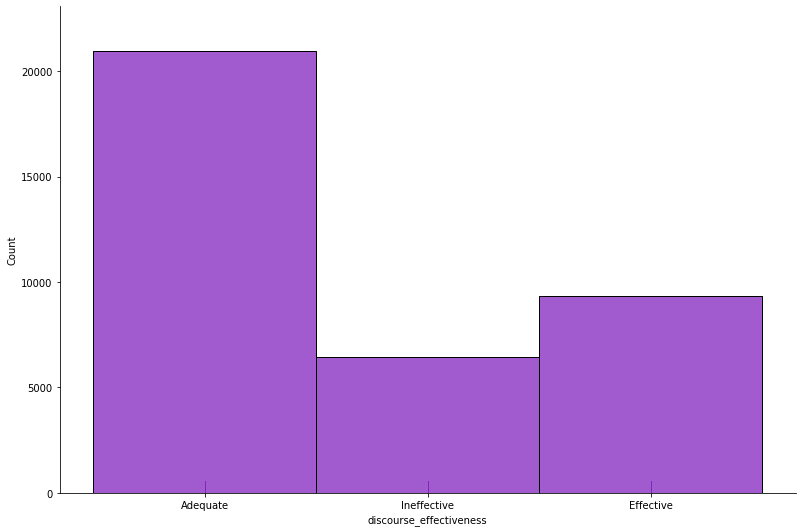

In [10]:
sns.displot(train["discourse_effectiveness"], color = "#8224BF", rug = True, height = 7.5, aspect = 1.5)

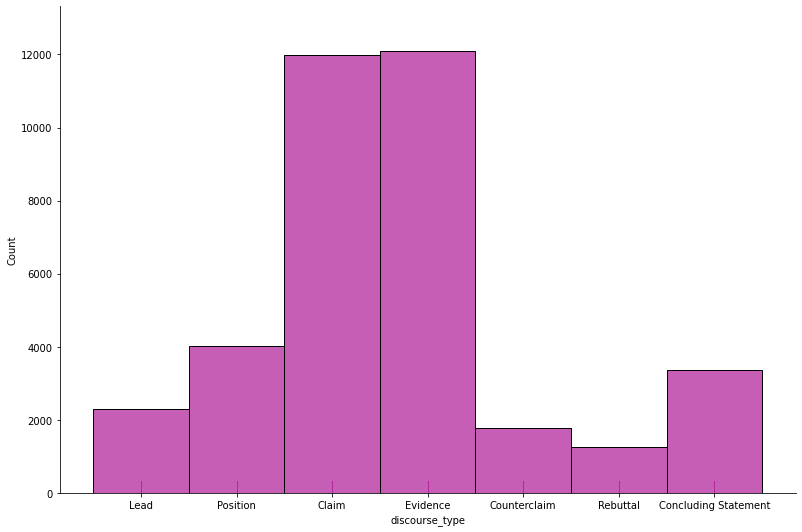

In [11]:
sns.displot(train["discourse_type"], color = "#B3289C", rug = True, height = 7.5, aspect = 1.5)

WORDCLOUD

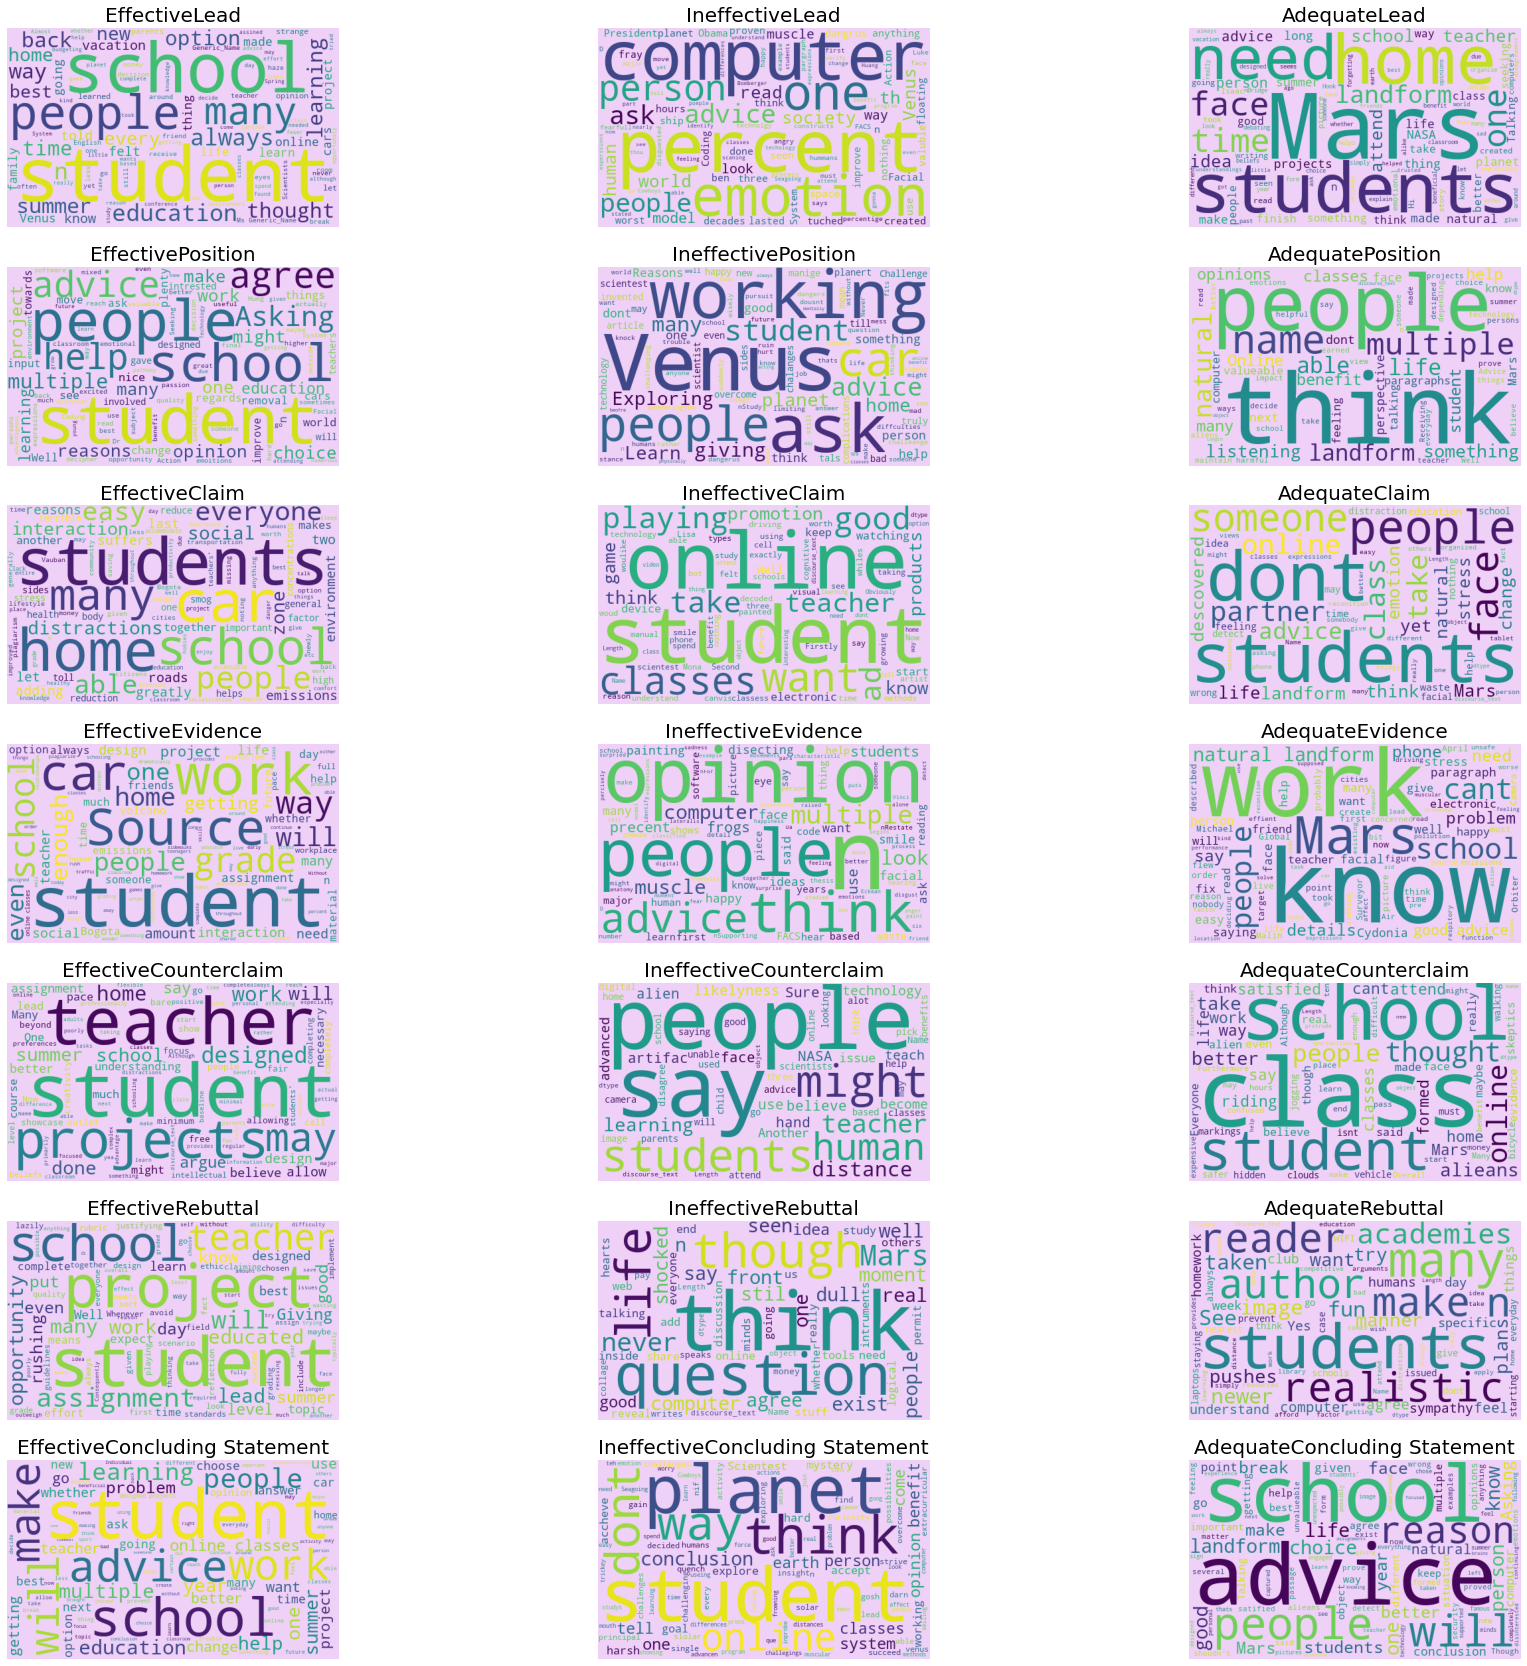

In [12]:
fig, ax = plt.subplots(7, 3, sharex = "col", sharey = "row", figsize = (30, 30))

for i, disty in enumerate(train["discourse_type"].unique()):
    for j, effect in enumerate(set(train["discourse_effectiveness"].values)): 
        word_cloud = WordCloud(background_color = "#EFD0F7", width = 500, height = 300, max_words = 100).generate(str(train.query(f'discourse_type == "{disty}" and discourse_effectiveness == "{effect}"')['discourse_text']))
        ax[i,j].imshow(word_cloud)
        ax[i,j].axis("off")
        ax[i,j].set_title(f'{effect}{disty}', fontsize = 20)
plt.show()

PIE CHART

([<matplotlib.patches.Wedge at 0x2eb1126e220>,
 [Text(0.95568025786856, 1.6073503801972622, 'Evidence'),
  Text(-1.967597671732368, 0.09725945811778283, 'Claim'),
  Text(-0.5179223716915707, -2.0041597782864966, 'Position'),
  Text(0.7994684775024362, -2.0173621770718158, 'Concluding Statement'),
  Text(1.719443231436302, -1.4820306926200577, 'Lead'),
  Text(2.214629558643973, -0.843988102985109, 'Counterclaim'),
  Text(2.4560579008319436, -0.26206790677415365, 'Rebuttal')],
 [Text(0.43440011721298183, 0.7306138091805736, '32.92534%'),
  Text(-0.9488415168252535, 0.046901769143093235, '32.57718%'),
  Text(-0.262714246510217, -1.0166027860873532, '10.94519%'),
  Text(0.42368145121096845, -1.069108987849119, '9.11465%'),
  Text(0.9468299732578755, -0.8160961963766837, '6.23147%'),
  Text(1.2614978498604907, -0.4807527168902519, '4.82252%'),
  Text(1.441815366885149, -0.1538455323168108, '3.38365%')])

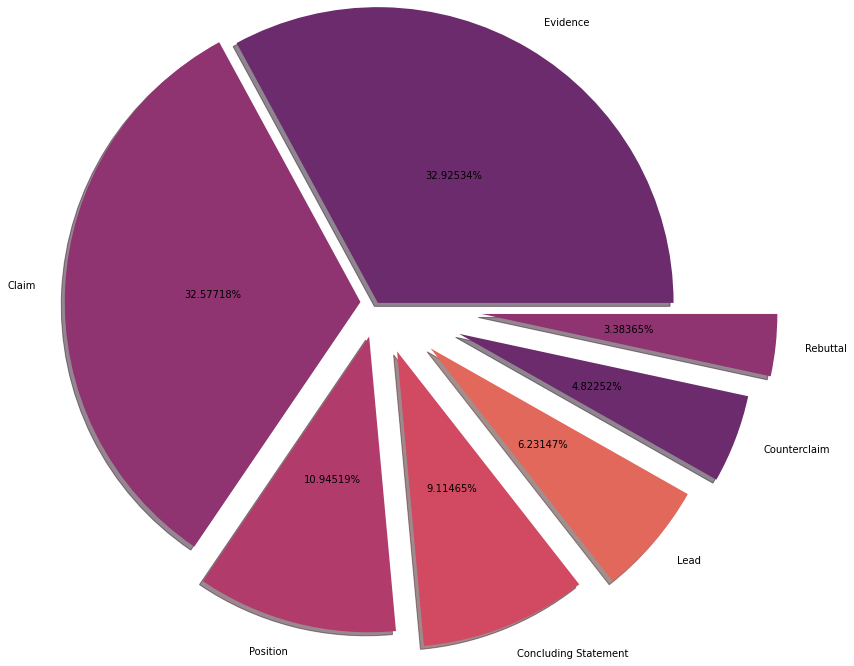

In [13]:
fig, ax = plt.subplots(figsize = (20,8))

data = train["discourse_type"].value_counts()
labels = train["discourse_type"].value_counts().index 
colors = sns.color_palette('flare')[5:0:-1]

plt.pie(data,
        labels = labels, 
        radius = 1.7, 
        shadow = True, 
        explode = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
        pctdistance = 0.5, 
        colors = colors, 
        autopct = '%0.5f%%')

([<matplotlib.patches.Wedge at 0x2eb11171880>,
 [Text(-0.41119411328332073, 1.8242311808543192, 'Adequate'),
  Text(-0.6392601088680934, -1.863396499194402, 'Effective'),
  Text(1.7623606064020048, -1.0858107998184392, 'Ineffective')],
 [Text(-0.18690641512878212, 0.8291959912974177, '57%'),
  Text(-0.30827264133232934, -0.8985922204236964, '25%'),
  Text(0.8939510322329008, -0.5507735941108025, '18%')])

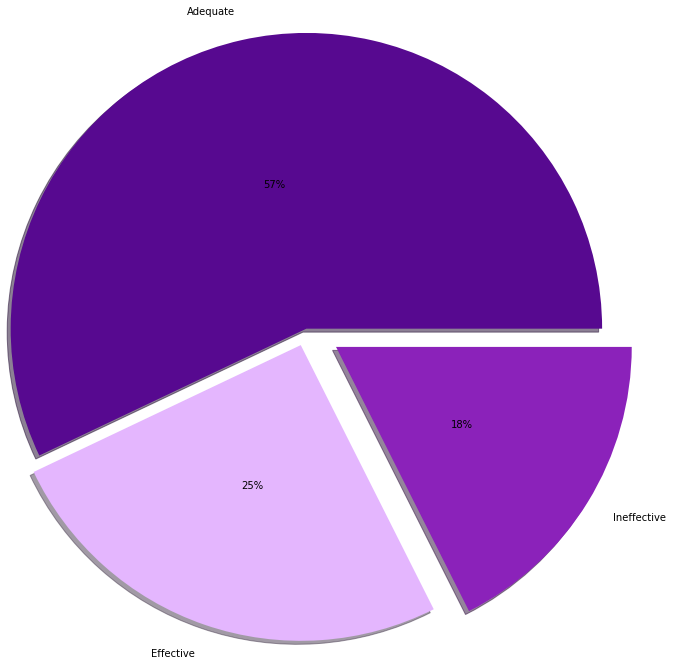

In [14]:
fig, ax = plt.subplots(figsize = (20, 8))

data = train["discourse_effectiveness"].value_counts()
labels = train["discourse_effectiveness"].value_counts().index 
colors = ["#570990", "#E4B6FE", "#8B22BA"]


plt.pie(data, 
        labels = labels, 
        radius = 1.7, 
        shadow = True, 
        pctdistance = 0.5, 
        explode = [0,0.1,0.2], 
        colors = colors, 
        autopct = '%.0f%%')


GIVE NUMBERS TO CATEGORICAL VARIABLES

In [15]:
train["discourse_effectiveness"].replace("Effective", value = 1, inplace = True)
train["discourse_effectiveness"].replace("Adequate", value = 2, inplace = True)
train["discourse_effectiveness"].replace("Ineffective", value = 3, inplace = True)

train.head(n = 7).style.background_gradient(cmap = "Purples_r")

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,2
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,2
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,2
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,2
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,2
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, I think that there is no life on Mars.",Rebuttal,3
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform.",Evidence,2


BOXPLOT

TypeError: boxplot() got multiple values for argument 'data'

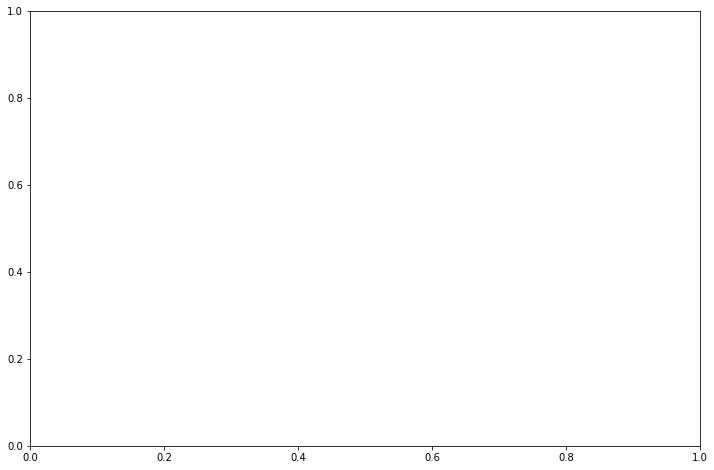

In [16]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot("discourse_effectiveness", data = train, saturation = 1, color = "#621378", 
            linewidth = 3,  width = 0.4, ax = ax)

WORD PROCESSING

Main Operations on the Text values: 

In [17]:
target_var = train["discourse_effectiveness"]

train_test = train.drop(["discourse_effectiveness"], axis = 1).append(test)

In [18]:
text = train_test["discourse_text"] + train_test["discourse_type"]
text.head(n=3)

0    Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. Lead
1    On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform Position                                                                                                       
2    I think that the face is a natural landform because there is no life on Mars that we have descovered yet Claim                                                                                                                                                                                                                   
dtype: object

In [19]:
#upper - lower letter conversion
text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))


#remove punctuation marks
text = text.str.replace('[^\w\s]','')


#remove numbers
text = text.str.replace('\d','')


#remove stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
text = text.apply(lambda x: " ".join(x for x in x.split() if x not in sw))


#remove infrequent words
remove = pd.Series(' '.join(text).split()).value_counts()[-1000:]
text = text.apply(lambda x: " ".join(x for x in x.split() if x not in remove))


#lemmatization
from textblob import Word
#nltk.download('wordnet')
text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


#remove hash tags
text = text.str.replace("#", " ")


#remove words less than two characters
text = text.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))


#remove special characters and numbers
text = text.apply(lambda x : re.sub("[^a-z\s]","", x))


#remove rare words
text_list = text.str.split().tolist()
#compute global word frequency
c = Counter(chain.from_iterable(text_list))

text = [' '.join([j for j in i if c[j] > 1]) for i in text_list]


print(colored("\nALL OPERATIONS ON THE TEXTS WERE SUCCESFULLY IMPLEMENTED", "green"))


ALL OPERATIONS ON THE TEXTS WERE SUCCESFULLY IMPLEMENTED


In [20]:
text = pd.Series(text)
type(text)

pandas.core.series.Series

In [21]:
text.head(n = 7)

0    going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform lead                                             
1    perspective think face natural landform dont think life mar next paragraph ill talking think natural landform position                                                                                          
2    think face natural landform life mar descovered yet claim                                                                                                                                                       
3    life mar would know reason think natural landform nobody live mar order create figure say paragraph easy target cydonia saying easy know natural landform point theyre saying probably natural landform evidence
4    people thought face formed alieans thought life mar counterclaim                                                                           

Count Words

In [22]:
cw = text.str.findall(r'(\w+)').str.len()
print(cw.sum())

821774


Convert Apostrophes

In [24]:
apostrophes = {
    "ain't" : "am not / are not", 
    "aren't" : "are not / are not", 
    "can't" : "cannot", 
    "can't've" : "cannot have", 
    "cause" : "because", 
    "could've" : "could have", 
    "couldn't" : "could not", 
    "couldn't've" : "could not have", 
    "didn't" : "did not", 
    "doesn't" : "does not", 
    "don't" : "do not", 
    "hadn't" : "had not", 
    "hadn't've": "had not have", 
    "hasn't" : "has not", 
    "haven't" : "have not", 
    "he'd" : "he had/ he would", 
    "he'd've" : "he would have", 
    "he'll" : "he shall / he will", 
    "he'll've" : "he shall have / he will have", 
    "he's" : "he has / he is", 
    "how'd" : "how did", 
    "how'd'y" : "how do you", 
    "how'll" : "how will", 
    "how's" : "how has / how is", 
    "i'd" : "I had / I would", 
    "i'd've" : "I would have", 
    "i'll" : "I shall / I will", 
    "i'll've" : "I shall have / I will have", 
    "i'm" : "I am", 
    "i've" : "I have", 
    "isn't" : "is not", 
    "it'd" : "it had / it would", 
    "it'd've" : "it would have", 
    "it'll" : "it shall / it will", 
    "it'll've" : "it shall have / it will have", 
    "it's" : "it has / it is", 
    "let's" : "let us", 
    "ma'am" : "madam", 
    "mayn't" : "may not", 
    "might've" : "might have", 
    "mightn't" : "might not", 
    "mightn't've" : "might not have", 
    "must've" : "must have", 
    "mustn't" : "must not", 
    "mustn't've" : "must not have", 
    "needn't" : "need not", 
    "needn't've" : "need not have", 
    "o'clock" : "of the clock", 
    "oughtn't" : "ought not", 
    "oughtn't've" : "ought not have", 
    "shan't" : "shall not", 
    "shan't've" : "shall not have", 
    "she'd" : "she had / she would", 
    "she'd've" : "she would have", 
    "she'll" : "she shall / she will", 
    "she'll've" : "she shall have / she will have", 
    "she's" : "she has / she is", 
    "should've" : "should have", 
    "shouldn't" : "should not", 
    "shouldn't've" : "should not have", 
    "so've" : "so have", 
    "so's" : "so as / so is", 
    "that'd" : "that would / that had", 
    "that'd've" : "that would have", 
    "that's" : "that has / that is", 
    "there'd" : "there had / there is", 
    "there'd've" : "there would have", 
    "there's" : "there is / there has", 
    "they'd" : "they had / they would", 
    "they'd've" : "they would have", 
    "they'll" : "they shall / they will", 
    "they'll've": "they shall have / they will have", 
    "they're" : "they are", 
    "they've" : "they have", 
    "to've" : "to have", 
    "wasn't": "was not", 
    "we'd" : "we had / we would", 
    "we'd've" : "we would have", 
    "we'll" : "we will", 
    "we'll've": "we will have", 
    "we're" : "we are", 
    "we've" : "we have", 
    "weren't" : "were not", 
    "what'll" : "what shall / what will", 
    "what'll've" : "what will have / what shall have", 
    "what're" : "what are", 
    "what's" : "what has / what is", 
    "what've" : "what have", 
    "when's" : "when has / when is", 
    "when've" : "when have", 
    "where'd" : "where did", 
    "where's" : "where has / where is", 
    "where've" : "where have", 
    "who'll" : "who shall / who will", 
    "who'll've" : "who shall have / who will have", 
    "who's" : "who has / who is", 
    "who've" : "who have", 
    "why's" : "why has / why is", 
    "why've": "why have", 
    "will've" : "will have", 
    "won't" : "will not", 
    "won't've" : "will not have", 
    "would've" : "would have", 
    "wouldn't" : "would not", 
    "wouldn't've" : "would not have", 
    "y'all" : "you all", 
    "y'all'd" : "you all would", 
    "y'all'd've" : "you all would have", 
    "y'all're" : "you all are", 
    "y'all've" : "you all have", 
    "you'd" : "you had / you would", 
    "you'd've" : "you had have / you would have", 
    "you'll" : "you shall / you will", 
    "you'll've" : "you shall have / you will have", 
    "you're": "you are", 
    "you've" : "you have"
}

def look_at_dict(txt, dictionary): 
    for word in txt.split(): 
        if word.lower() in dictionary: 
            if word.lower() in txt.split(): 
                txt = txt.replace(word, dictionary[word.lower()])
                
    return txt 

text = text.apply(lambda x: look_at_dict(x,apostrophes))

text.head()

0    going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform lead                                             
1    perspective think face natural landform dont think life mar next paragraph ill talking think natural landform position                                                                                          
2    think face natural landform life mar descovered yet claim                                                                                                                                                       
3    life mar would know reason think natural landform nobody live mar order create figure say paragraph easy target cydonia saying easy know natural landform point theyre saying probably natural landform evidence
4    people thought face formed alieans thought life mar counterclaim                                                                           

Split Train and Test Datasets and Target

ONE-HOT ENCODING: 

In the step of data processing in machine learning, we often need to prepare our data in specific ways before feeding into a machine learning model. One of the examples is to perform a One-Hot encoding on categorical data. One Hot Encoding is a process in the data processing that is applied to categorical data, to convert it into a binary vector representation for use in machine learning algorithms

One of the major problems with machine learning is that a lot of algorithms cannot work directly with categorical data. Categorical data are variables that can take on one of a limited number of possible values. Some examples are:

The sex of a person: female or male.
The airline travel class: First Class, Business Class, and Economy Class.
The computer vendor: Lenovo, HP, Dell, Apple, Acer, Asus, and Others.
Therefore, we need a way to convert categorical data into a numerical form and our machine learning algorithm can take in that as input. The most widely used encoding techniques are:

Integer Encoding: encodes the values as integer.
One-Hot Encoding: encodes the values as a binary vector array.
Dummy Variable Encoding: same as One-Hot Encoding, but one less column.
In the above examples, each value in a categorical variable represents a different category. Some categories may have a natural relationship (known as a natural ordering) to each other. The airline travel class variable does have a natural ordering of values. This type of categorical variable is known as an ordinal variable. Ordinal variables should be treated differently in machine learning because the ordinality generally comes with some significance. In the case of airline travel class, the passengers in the higher classes tend to be wealthier and older. 

Integer Encoding representation: The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to learn this relationship.

For categories variables where no such ordinal relationship exists, Integer Encoding could result in poor performance or unexpected results. Fortunately, One-Hot Encoding is a way to combat this. One-Hot Encoding simply creates one column for every possible value and put a 1 in the appropriate column. Below is the equivalent One-Hot Encoding representation.

One-Hot Encoding representation: With One-Hot Encoding, the binary vector arrays representation allows a machine learning algorithm to leverage the information contained in a category value without the confusion caused by ordinality.

However, there is some redundancy in One-Hot encoding. For instance, in the above example, if we know that a passenger’s flight ticket is not First Class and not Economy Class, then it must be Business Class. So we only need to use two of these three dummy-coded variables as a predictor. More generally, the number of dummy-coded variables needed is one less than the number of possible values, which is K-1. In statistics, this is called a dummy encoding variable, or dummy variable. Below is the equivalent dummy encoding variable representation:


Dummy Encoding variable representation: Dummy encoding variable is a standard advice in statistics to avoid the dummy variable trap, However, in the world of machine learning, One-Hot encoding is more recommended because dummy variable trap is not really a problem when applying regularization.

In [25]:
x_train = text[:len(train)]
y_train = pd.get_dummies(target_var)
x_test = text[len(train):]

In [26]:
x_train.head()

0    going writing face mar natural landform life mar made story nasa took picture mar face seen planet nasa doesnt know landform created life mar natural landform lead                                             
1    perspective think face natural landform dont think life mar next paragraph ill talking think natural landform position                                                                                          
2    think face natural landform life mar descovered yet claim                                                                                                                                                       
3    life mar would know reason think natural landform nobody live mar order create figure say paragraph easy target cydonia saying easy know natural landform point theyre saying probably natural landform evidence
4    people thought face formed alieans thought life mar counterclaim                                                                           

In [27]:
y_train.head(n = 10).style.background_gradient(cmap = "Purples_r")

,1,2,3
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,0,1
6,0,1,0
7,0,1,0
8,0,1,0
9,1,0,0


In [28]:
x_test[0:3]

36765    making choice life difficult people often ask advice decide one thing always good ask others advice making choice multiple opinion ability make best choice lead
36766    seeking multiple opinion help person make better choice position                                                                                                
36767    decrease stress level claim                                                                                                                                     
dtype: object

LOGISTIC REGRESSION AND XGBOOST WITH TFIDF VECTORIZER METHOD 

Most machine learning algorithms are fulfilled with mathematical things such as statistics, algebra, calculus and etc. They expect the data to be numerical such as a 2-dimensional array with rows as instances and columns as features. The problem with natural language is that the data is in the form of raw text, so that the text needs to be transformed into a vector. The process of transforming text into a vector is commonly referred to as text vectorization. It’s a fundamental process in natural language processing because none of the machine learning algorithms understand a text, not even computers. Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.

Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. It combines 2 concepts, Term Frequency (TF) and Document Frequency (DF).

The term frequency is the number of occurrences of a specific term in a document. Term frequency indicates how important a specific term in a document. Term frequency represents every text from the data as a matrix whose rows are the number of documents and columns are the number of distinct terms throughout all documents.

Document frequency is the number of documents containing a specific term. Document frequency indicates how common the term is.

Inverse document frequency (IDF) is the weight of a term, it aims to reduce the weight of a term if the term’s occurrences are scattered throughout all the documents.



Tfidf Vectorizer Operations: 

In [29]:
vectorizer_tfidf = TfidfVectorizer(stop_words = "english", max_df = 0.5, min_df = 0.01)

x_train = np.array(x_train).tolist()
x_train = list(map(''.join, x_train))

x_test = np.array(x_test).tolist()
x_test = list(map(''.join, x_test)) 

vectorizer_tfidf.fit(x_train)
x_train_tfidf_word_level = vectorizer_tfidf.transform(x_train)
x_test_tfidf_word_level = vectorizer_tfidf.transform(x_test)

print(colored("\nVECTORIZATION PROCESS SUCCESSFULLY COMPLETED", "green"))


VECTORIZATION PROCESS SUCCESSFULLY COMPLETED


In [30]:
vectorizer_tfidf.get_feature_names()[0:5]

['able', 'accident', 'according', 'action', 'activity']

In [31]:
x_train_tfidf_word_level.shape, x_test_tfidf_word_level.shape

((36765, 288), (10, 288))

LOGISTIC REGRESSION 

What is logistic regression?

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds - that is, the probability of success divided by the probability of failure. This is also commonly known as the log odds, or the natural logarithm of odds, and this logistic function is represented by the following formulas:

Logit(pi) = 1/(1+ exp(-pi))

ln(pi/(1-pi)) = Beta_0 + Beta_1X_1 + … + B_kK_k</b></mark>

In this logistic regression equation, logit(pi) is the dependent or response variable and x is the independent variable. The beta parameter, or coefficient, in this model is commonly estimated via maximum likelihood estimation (MLE). This method tests different values of beta through multiple iterations to optimize for the best fit of log odds. All of these iterations produce the log likelihood function, and logistic regression seeks to maximize this function to find the best parameter estimate. Once the optimal coefficient (or coefficients if there is more than one independent variable) is found, the conditional probabilities for each observation can be calculated, logged, and summed together to yield a predicted probability. For binary classification, a probability less than .5 will predict 0 while a probability greater than 0 will predict 1. After the model has been computed, it’s best practice to evaluate the how well the model predicts the dependent variable, which is called goodness of fit. The Hosmer–Lemeshow test is a popular method to assess model fit.


In [32]:
log_model = MultiOutputClassifier(LogisticRegression())
log_model.fit(x_train_tfidf_word_level, y_train)
print(log_model.score(x_train_tfidf_word_level, y_train))

0.5508499932000543


Extreme Gradient Boosting

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models.

When using gradient boosting for regression, the weak learners are regression trees, and each regression tree maps an input data point to one of its leafs that contains a continuous score. XGBoost minimizes a regularized (L1 and L2) objective function that combines a convex loss function (based on the difference between the predicted and target outputs) and a penalty term for model complexity (in other words, the regression tree functions). The training proceeds iteratively, adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final prediction. It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [33]:
xgb_model = MultiOutputClassifier(XGBClassifier())
xgb_model.fit(x_train_tfidf_word_level, y_train)
print(xgb_model.score(x_train_tfidf_word_level, y_train))

0.6645722834217326


LOGISTIC REGRESSION AND XGBOOST WITH COUNT VECTORIZER METHOD

In [34]:
count_vectorizer = CountVectorizer(stop_words = "english", max_df = 0.5, min_df = 0.01)
count_vectorizer.fit(x_train)

x_train_count = count_vectorizer.transform(x_train)
x_test_count = count_vectorizer.transform(x_test)

In [35]:
count_vectorizer.get_feature_names()[0:10]

['able',
 'accident',
 'according',
 'action',
 'activity',
 'actually',
 'advice',
 'agree',
 'alien',
 'allow']

In [37]:
log_model = MultiOutputClassifier(LogisticRegression())
log_model.fit(x_train_count, y_train)
print(log_model.score(x_train_count, y_train))

0.5827281381748945


In [38]:
xgb_model = MultiOutputClassifier(XGBClassifier())
xgb_model.fit(x_train_count, y_train) 
print(xgb_model.score(x_train_count, y_train))

0.6631306949544403


USE XGBOOST MODEL ON TFIDFVECTORIZER METHOD

In [39]:
xgb_model = MultiOutputClassifier(XGBClassifier(n_estimators = 100))

xgb_model.fit(x_train_tfidf_word_level, y_train)
print(xgb_model.score(x_train_tfidf_word_level, y_train))

0.6645722834217326


What is Multi-Output Classification?


Multi-output classification is a type of machine learning that predicts multiple outputs simultaneously. In multi-output classification, the model will give two or more outputs after making any prediction. In other types of classifications, the model usually predicts only a single output.

An example of a multi-output classification model is a model that predicts the type and color of fruit simultaneously. The type of fruit can be, orange, mango and pineapple. The color can be, red, green, yellow, and orange. The multi-output classification solves this problem and gives two prediction results.

In [40]:
prediction = xgb_model.predict(x_test_tfidf_word_level)
prediction

array([[0, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0]])

In [41]:
prediction = pd.DataFrame(prediction, columns = ["Ineffective", "Adequate", "Effective"])
prediction.style.background_gradient(cmap = "Purples_r")

,Ineffective,Adequate,Effective
0,0,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,0
5,0,1,0
6,1,0,0
7,1,0,0
8,0,0,0
9,1,0,0


In [42]:
prediction["discourse_id"] = submission_sample["discourse_id"]
titles = ['discourse_id', 'Ineffective', 'Adequate', 'Effective']
prediction = prediction.reindex(columns = titles)
prediction.style.background_gradient(cmap = "Purples_r")

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0,0,0
1,5a88900e7dc1,0,1,0
2,9790d835736b,0,1,0
3,75ce6d68b67b,0,1,0
4,93578d946723,0,0,0
5,2e214524dbe3,0,1,0
6,84812fc2ab9f,1,0,0
7,c668ff840720,1,0,0
8,739a6d00f44a,0,0,0
9,bcfae2c9a244,1,0,0


In [43]:
submission = pd.DataFrame(prediction)
submission.to_csv('submission.csv', index = False)
print("My Submission: \n\n", submission)

My Submission: 

    discourse_id  Ineffective  Adequate  Effective
0  a261b6e14276  0            0         0        
1  5a88900e7dc1  0            1         0        
2  9790d835736b  0            1         0        
3  75ce6d68b67b  0            1         0        
4  93578d946723  0            0         0        
5  2e214524dbe3  0            1         0        
6  84812fc2ab9f  1            0         0        
7  c668ff840720  1            0         0        
8  739a6d00f44a  0            0         0        
9  bcfae2c9a244  1            0         0        
